<a href="https://colab.research.google.com/github/AnIsAsPe/RNN-Resumenes-de-Texto/blob/main/Notebooks/Resumen_de_textos_usando_seq2seq_LSTM_w2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANTE: Antes de iniciar cambiar entorno de ejecución a GPU

# Cargar bibliotecas y Embeddings preentrenados

In [1]:
!pip install contractions

     |████████████████████████████████| 287 kB 7.1 MB/s 
     |████████████████████████████████| 106 kB 61.2 MB/s 


<h3>Bibliotecas<h3>

In [2]:
import pandas as pd
import numpy as np
import gensim
import contractions
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow import keras
from tensorflow.data import Dataset  # Convierte conjuntos de datos de Python a tensores
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization  # Crear diccionario para convertir palabras a indices y vs.
from tensorflow.keras.preprocessing.sequence import pad_sequences # Rellenar con cero los vectores de las secuencias hasta la longitud máxima
from tensorflow.keras.layers import Embedding, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate #, Attention
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

<h3>Modelo Preentrenado Word2Vec<h3>

Utilizaremos los vectores word2vec preentrenados con el corpus GoogleNews.
Cuenta con 3 millones vectores de 300 dimensiones correspondientes a 3  palabras y frases en inglés. 
Crea un acceso directo en tu drive del modelo preentrenado que está disponible en este [enlace](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g)


In [3]:
# asegurate de poner la ruta correcta en donde se ubica el archivo en tu drive
file =  '/content/drive/MyDrive/Embeddings/GoogleNews-vectors-negative300.bin.gz'  
w2v = gensim.models.KeyedVectors.load_word2vec_format(file,  binary=True)

In [4]:
print('Palabras en el modelo w2v: {:,} '.format(len(w2v.vocab)))
print('Dimensiones por embedding: ', w2v.vector_size)

Palabras en el modelo w2v: 3,000,000 
Dimensiones por embedding:  300


In [ ]:
%%time
dic_embeddings_word2vec  = {palabra : w2v[palabra] for palabra in w2v.index2word}

CPU times: user 5.6 s, sys: 290 ms, total: 5.89 s
Wall time: 5.89 s


# Funciones

In [ ]:
def preprocesar(texto):
    #quitar contracciones
    texto = contractions.fix(texto)

    #convertir en minúsculas
    texto = texto.lower()

    # eliminar texto no deseado
    texto = re.sub(r'<br />', ' ', texto)

    #texto = re.sub(r'https?:\/\/.*[\r\n]*', '', texto, flags=re.MULTILINE)
    #texto = re.sub(r'\<a href', ' ', texto)
    #texto = re.sub(r'&amp;', '', texto) 
    #texto = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', texto)
    #texto = re.sub(r'\'', ' ', texto)

    #dejar solo letras y números
    texto = re.sub('[^A-ZÜÖÄa-z0-9]+', ' ', texto)
    return(texto)

In [ ]:
def Vectorizer(serie_pd, max_tokens= 20000):
    '''Crear diccionario para convertir palabras en índices
     '''
    text_ds = Dataset.from_tensor_slices(serie_pd).batch(128)  # transforma la serie a tensores
    vectorizer = TextVectorization(max_tokens = max_tokens  )  
    vectorizer.adapt(text_ds)   #similar a fit 
    return  vectorizer

In [ ]:
def vectores_palabras(dic_vocabulario, dic_embeddings_palabras, embedding_dim):
    '''Obtiene una matriz donde cada renglón es el 'embedding vector' de una 
    palabra del vocabulario '''
    num_tokens = len(dic_vocabulario.keys()) 
    encontradas = 0
    # Inicializar matriz
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in dic_vocabulario.items():
        embedding_vector = dic_embeddings_palabras.get(word)
        if embedding_vector is not None:
            # los vectores no encontrados en el embeding se quedan en cero
            embedding_matrix[i] = embedding_vector
            encontradas += 1
    proporcion = encontradas/len(dic_vocabulario) *100
    print("{} palabras vectorizadas, que representan {:.1f}% de todas las palabras en el corpus".format(encontradas, proporcion))
    return embedding_matrix

In [ ]:
def crea_resumen(input_seq):
    # Codifica el texto como vectores de entrada
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # Genera una secuencia vacía de longitud 1.
    target_seq = np.zeros((1,1))

    # Identifica la palabra 'tokenstart' como la primera palabra de la secuencia objetivo
    target_seq[0, 0] =  palabras_indices_resumen['tokenstart']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # Escoje la próxima palabra para el resumen
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = indices_palabras_resumen[sampled_token_index]

        # Mientras la palabra elejida no sea la final 'tokenend', anexa la palabra elejida al resumen
        if sampled_token!='tokenend':
            decoded_sentence += ' '+ sampled_token

        # Sal del ciclo while si se alcanza la longitud máxima o si se encuentra 'tokenend'.
        if (sampled_token == 'tokenend' or len(decoded_sentence.split()) >= (int(longitud_max_resumen-1))):
                stop_condition = True

        # Actualiza la secuencia objetivo (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Actualiza los estados internos para predecir la siguiente palabra, igualandolos al estado del tiempo anterior
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    '''obtiene el resumen, partiendo de los inidices correspondiente a cada palabra'''
    newString = ''
    for i in input_seq:
      if((i != 0 and i != palabras_indices_resumen['tokenstart']) and i != palabras_indices_resumen['tokenend']):
        newString = newString + indices_palabras_resumen[i]+' '
    return newString

def seq2text(input_seq):
    '''obtiene la reseña, partiendo de los inidices correspondiente a cada palabra'''
    newString = ''
    for i in input_seq:
      if(i != 0):
        newString = newString + indices_palabras_reseña[i]+' '
    return newString

# Lectura de Datos y preparación de secuencias

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datos/AmazonReviews/Reviews.csv',
                 nrows=500000, usecols=['Summary', 'Text'], )
df = df.drop_duplicates(keep='first', ignore_index = True).dropna()
print(df.shape)
df.head()

(353877, 2)


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 309544
A Hit, A Real Crowd Pleaser
I ordered a couple of these for Christmas Gifts and they were a big hit.  The ingredients were tasty and plump... the packaging nicely done and would definitely consider re-ordering for next year.

Review # 214955
Taste is GREAT!
A local bakery here sells Cinnamon Chip bread.  I was able to google a recipe & bought these chips to use.  I learned the hard way that these melt easily.  If you add them to bread machine dough, they will melt making your dough very runny.  Instead, I set my machine to dough setting & after it has risen, I roll it out & sprinkle these on top, then roll it up for a loaf.  Turned out very yummy without the melting problem.  Very tasty!

Review # 23283
Amazing snack
Can't say enough about these chips.  They are only 3 Weight watchers points and are very satisfying.  Hard to believe they are healthy.  I like the portion control of single serve bags for myself and they are quick to pack in a lunch.  One of these bags is

## Preprocesamiento de texto
- convertir a minuscualas
- expandir contracciones
- eliminar puntuación


In [ ]:
%%time
for col in df.columns:
  df[col] = df[col].apply(preprocesar)


CPU times: user 21.3 s, sys: 91.3 ms, total: 21.4 s
Wall time: 22.6 s


## Agregar token que identifique el inicio y el final de la secuencia objetivo (resúmenes).

In [ ]:
df['Summary'] = df['Summary'].apply(lambda x : 'tokenstart '+ x + ' tokenend')  #Identificador de comienzo y término

In [ ]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 82737
tokenstart think everything bagels  tokenend
as someone who has not been able to eat gluten for the past couple of years this chip brought back memories of my favorite everything bagels that i used to eat regularly they are quite delicious 

Review # 245117
tokenstart unique flavor found in no other sauce love it  tokenend
i agree with the lady who stated this is the spaghetti that i remember from my childhood i have lived in many states and other countries my box spaghetti has been hard to find in many places it is always something i ask people to send me and i always look to stock up on when i come home it is a little spicy but oh so good a great comfort food i am also afraid that they will stop making it so try it we need more loyal fans 

Review # 245937
tokenstart omg tokenend
this is the reason being human is great wonderful product i had my doubts before ordering but not after tasting and tasting and tasting 

Review # 142171
tokenstart delicious tokenend
the che

## Fijar longitud máxima de palabras en textos y resumenes

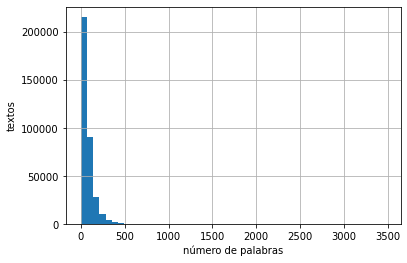


El 90% de los textos tiene 164 palabras


In [ ]:
# ¿Cuantas palabras tienen cada texto?
palabras_reseña = df['Text'].apply(lambda x: len(str(x).split()))

hist = palabras_reseña.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("textos")
plt.show()

print('\nEl 90% de los textos tiene {:,.0f} palabras'.format(palabras_reseña.quantile(0.90)))

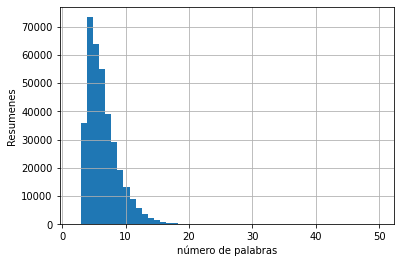


El 97.5% de los resumenes tiene 13 palabras


In [ ]:
# ¿Cuantas palabras tienen cada titulo?
palabras_resumen = df['Summary'].apply(lambda x: len(str(x).split()))

hist = palabras_resumen.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("Resumenes")
plt.show()

print('\nEl 97.5% de los resumenes tiene {:,.0f} palabras'.format(palabras_resumen.quantile(0.975)))

In [ ]:
longitud_max_reseña = palabras_reseña.quantile(0.90)     #164 palabras
longitud_max_resumen = palabras_resumen.quantile(0.975)  # 13 palabras

In [ ]:
datos =  df[(palabras_reseña <= longitud_max_reseña ) & (palabras_resumen <= longitud_max_resumen)]
datos.shape   

(314856, 2)

# Dividir datos en conjunto de entrenamiento y prueba

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(datos['Text'], 
                                                    datos['Summary'], 
                                                    test_size=0.1, 
                                                    shuffle=True, 
                                                    random_state=0)
print('{} reseñas en el conjunto de entrenamiento\n{} reseñas en el conjunto de prueba'.format(len(x_train), len(x_test)))

283370 reseñas en el conjunto de entrenamiento
31486 reseñas en el conjunto de prueba


# Preparar las secuencias para ingresar al modelo

[Referencia](https://keras.io/examples/nlp/pretrained_word_embeddings/):


### 1)  Crear diccionario para convertir palabras en índices (en el entrenamiento) y otro para regresar índices a palabras (durante la predicción)

In [ ]:
%%time
vectorizer_reseña = Vectorizer(x_train)

# Diccionarios de la secuencia de entrada
voc_reseña = vectorizer_reseña.get_vocabulary()  # lista con el vocabulario
palabras_indices_reseña = dict(zip(voc_reseña, range(len(voc_reseña))))
indices_palabras_reseña = dict(map(reversed, palabras_indices_reseña.items()))

CPU times: user 7.95 s, sys: 1.02 s, total: 8.97 s
Wall time: 9.62 s


In [ ]:
palabras_indices_reseña.keys()

dict_keys(['', '[UNK]', 'the', 'i', 'and', 'a', 'it', 'to', 'is', 'this', 'of', 'not', 'for', 'in', 'my', 'have', 'that', 'but', 'are', 'you', 'with', 'was', 'they', 'as', 'on', 'like', 'so', 'these', 'them', 'good', 'great', 'very', 'taste', 'product', 'will', 'be', 'at', 'just', 'one', 'or', 'do', 'flavor', 'if', 'coffee', 'all', 'would', 'am', 'we', 'love', 'from', 'tea', 'can', 'when', 'has', 'more', 'had', 'me', 'than', 'amazon', 'out', 'get', 's', 'no', 'really', 'other', 'too', 'some', 'only', 'up', 'much', 'use', 'were', 'about', 'buy', 'price', 'best', 'food', 'time', 'little', 'find', 'an', 'because', 'there', 'also', 'tried', 'what', 'your', 'make', 'been', 'better', 'did', 'well', 'does', 'even', 'try', 'chocolate', 'now', 'which', 'by', 'after', 'any', 'eat', 'again', 'he', 'she', 'used', 'bought', 'sugar', 'found', 'could', 'sweet', 'our', 'first', '2', 'cannot', 'free', 'order', 'store', 'delicious', 'tastes', 'drink', 'made', 'water', 'box', 'bag', 'cup', 'their', 'dog'

[UNK] es un token especial que se usara cuando se encuentren palabras que no están en el vocabulario.

In [ ]:
vectorizer_resumen = Vectorizer(y_train)
# Diccionarios de la secuencia de entrada
voc_resumen = vectorizer_resumen.get_vocabulary()  # lista con el vocabulario
palabras_indices_resumen = dict(zip(voc_resumen, range(len(voc_resumen))))
indices_palabras_resumen = dict(map(reversed, palabras_indices_resumen.items()))


In [ ]:
ejemplos = x_train.iloc[:2]
for ej in ejemplos:
  print(len(ej.split()))
  print(ej)

43
i have a german shepherd who was brought up with this food she looks great her coat is shiny and she is very very active i have no problem with the bynature products too bad i cannot get this food locally love it 
90
purchased the shampoo and conditioner after reading all the hype in magazines been using bed head products from my hair salon prior after 1 week using this i noticed my hair felt thinner and could feel more of my scalp this was a tad alarming my hair went to feeling somewhat healthy highlight my hair so has some processing stress but not much to feeling unhealthy texture was changed also noticed the color looked washed out after using products going in garbage can and back to shampoos conditioners from salon 


In [ ]:
ejemplos_vec = ejemplos.apply(vectorizer_reseña)
for ej in ejemplos_vec:
  print(len(ej))
  print(ej)

43
tf.Tensor(
[   3   15    5 1669 2855  139   21  998   68   20    9   76  104  625
   30  147 1351    8 2002    4  104    8   31   31 2335    3   15   62
  346   20    2    1  195   65  206    3  114   60    9   76  720   48
    6], shape=(43,), dtype=int64)
90
tf.Tensor(
[  233     2  1183     4  1397    99   864    44     2  4065    13 11747
    88   204  1440  1731   195    49    14   510  7975  2020    99   145
   483   204     9     3   749    14   510   946  2642     4   109   294
    54    10    14  1747     9    21     5  2222 13902    14   510   426
     7   933   950   181  9488    14   510    26    53    66  3442  3425
    17    11    69     7   933  2503   250    21   954    83   749     2
   587   607  3447    59    99   204   195   254    13  1861    51     4
   193     7  4428  5105    49  7975], shape=(90,), dtype=int64)


In [ ]:
%%time
x_train_vec = x_train.apply(vectorizer_reseña)
x_test_vec = x_test.apply(vectorizer_reseña)

y_train_vec = y_train.apply(vectorizer_resumen)
y_test_vec = y_test.apply(vectorizer_resumen)

CPU times: user 59min 28s, sys: 5min 6s, total: 1h 4min 35s
Wall time: 53min 22s


## 2) Rellenar cada secuencia hasta alcanzar la longitud máxima

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

ejemplos_seq =  pad_sequences(ejemplos_vec, maxlen = int(longitud_max_reseña), padding='post')
for ej in ejemplos_seq:
  print(len(ej))
  print(ej)

164
[   3   15    5 1669 2855  139   21  998   68   20    9   76  104  625
   30  147 1351    8 2002    4  104    8   31   31 2335    3   15   62
  346   20    2    1  195   65  206    3  114   60    9   76  720   48
    6    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
164
[  233     2  1183     4  1397    99   864    44     2  4065    13 11747
    88   204  1440  1731   195    49    14   510  7975  2020    99   145
   483   204 

In [ ]:
%%time

x_train_seq  =  pad_sequences(x_train_vec, maxlen = int(longitud_max_reseña), padding='post') 
x_test_seq  =  pad_sequences(x_test_vec, maxlen = int(longitud_max_reseña), padding='post') 

y_train_seq  =  pad_sequences(y_train_vec, maxlen = int(longitud_max_resumen) , padding='post') 
y_test_seq  =  pad_sequences(y_test_vec, maxlen = int(longitud_max_resumen) , padding='post') 

CPU times: user 3min 33s, sys: 17 s, total: 3min 50s
Wall time: 3min 14s


## 3) Obtener la matriz de vectores para todas las palabras del vocabulario 

In [ ]:
embedding_matrix_reseña = vectores_palabras(palabras_indices_reseña, dic_embeddings_word2vec , 300)
embedding_matrix_reseña.shape

17816 palabras vectorizadas, que representan 89.1% de todas las palabras en el corpus


(20000, 300)

In [ ]:
embedding_matrix_resumen = vectores_palabras(palabras_indices_resumen, dic_embeddings_word2vec , 300)
embedding_matrix_resumen.shape

14576 palabras vectorizadas, que representan 72.9% de todas las palabras en el corpus


(20000, 300)

## Guardamos en pickle los avances

In [ ]:
import pickle
path = '/content/drive/MyDrive/Pickle_ Datos entrada RNN/'
tuple_inputs = ((embedding_matrix_resumen, embedding_matrix_reseña),
                (x_train_seq, x_test_seq,  y_train_seq, y_test_seq),
                (palabras_indices_resumen, palabras_indices_reseña),
                (indices_palabras_resumen, indices_palabras_reseña)
                )
pickle.dump(tuple_inputs, open (path + "tuple_inputs_RNN.pkl", 'wb'))

<h2> Leemos los datos guardados

In [ ]:
import pickle
path = '/content/drive/MyDrive/Pickle_ Datos entrada RNN/'
tuple_inputs = pickle.load(open(path + "tuple_inputs_RNN.pkl", 'rb'))

embedding_matrix_resumen, embedding_matrix_reseña = tuple_inputs[0]
x_train_seq, x_test_seq,  y_train_seq, y_test_seq = tuple_inputs[1]
palabras_indices_resumen, palabras_indices_reseña = tuple_inputs[2]
indices_palabras_resumen, indices_palabras_reseña = tuple_inputs[3]


# Diseño del modelo

* [referencia1](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

* [referencia2](https://humboldt-wi.github.io/blog/research/information_systems_1920/nlp_text_summarization_techniques/) 

## Diseño del ENCODER  y DECODER
(Codificador y Descodificador)

El Encoder lee la secuencia de entrada (reseña) y resume la información en el vector interno de estado (hidden state) y el vector de contexto. Al decodificador solo pasará el vector de estado interno.

El Decoder es inicializado con las el ultimo hidden state del LSTM y con el primer toquen de la secuencia objetivo (resumen) para generar la secuencia de salida


In [ ]:
num_tokens_reseña = len(palabras_indices_reseña) 
num_tokens_resumen = len(palabras_indices_resumen)
embedding_dim = 300

In [ ]:
K.clear_session() 
latent_dim = 320  # neuronas ocultas en cada LSTM en cada tiempo t.

# ENCODER   ================================================================

## EMBEDDING
#recibe los indices que corresponden a las palabras de las reseñas y las 
#regresa con el vector correpondiente del embedding

encoder_inputs = Input(shape = (int(longitud_max_reseña),))

enc_emb_lay = Embedding(num_tokens_reseña, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_reseña),
                    trainable=False)
enc_emb = enc_emb_lay(encoder_inputs)     

#LSTM 1
# procesa la secuencia de entrada y regresa otra secuencia que pasara a la
# capa LSTM 2 
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 


# LSTM 2
# procesa la secuencia de de salida de la capa LSTM anterior  y regresa otra 
# secuencia que pasara a la capa LSTM 3
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
# procesa la secuencia de de salida de la capa LSTM anterior  y regresa otra 
# secuencia que pasara al mecanismo de atención y los estados h y c inicializarán
# el decodificador.

encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2) 


# DECODIFICADOR ================================================================

decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tokens_resumen, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_resumen),
                    trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM 
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 




## Mecanismo de atención

 [Fuente ](https://www.tensorflow.org/text/tutorials/nmt_with_attention)

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.Attention()

  def call(self, query, value,
          #  mask
           ):
    # shape_checker = ShapeChecker()
    # shape_checker(query, ('batch', 't', 'query_units'))
    # shape_checker(value, ('batch', 's', 'value_units'))
    # shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    # shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    # shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    # value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        # mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    # shape_checker(context_vector, ('batch', 't', 'value_units'))
    # shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [ ]:
attention = BahdanauAttention(latent_dim)

In [ ]:
context_vector, attention_weights = attention(decoder_outputs, encoder_outputs) # (query, value)

In [ ]:
# Unión del decoder con la capa de atención

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, context_vector])

# El Decoder calcula su salida mediante Softmax, que crea el vector de probabilidad 
# para determinar la secuencia final.

decoder_dense = TimeDistributed(Dense(embedding_matrix_resumen.shape[0], activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Modelo de entrenamiento

In [ ]:
# Modelo definitivo

# Tupla con las entradas y las salidas
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 



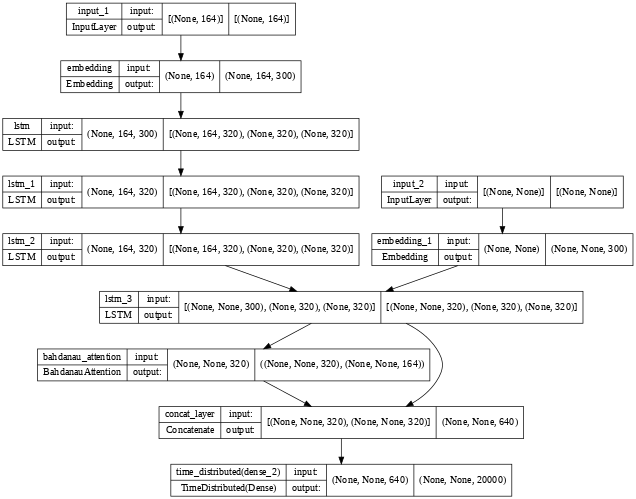

In [ ]:
tf.keras.utils.plot_model( 
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 164)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 164, 300)     6000000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 164, 320),   794880      ['embedding[0][0]']              
                                 (None, 320),                                                     
                                 (None, 320)]                                                     
                                                                                              

### Entrenamiento

In [ ]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy')

In [ ]:
#%%time

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1) 

history = model.fit([x_train_seq, y_train_seq[:,:-1]], 
                    y_train_seq.reshape(y_train_seq.shape[0],
                                        y_train_seq.shape[1], 1)[:,1:],
                    epochs = 20, 

                    #terminar antes cuando no disminuya la función de pérdida
                    #callbacks = [EarlyStopping(monitor='val_loss',mode='min', 
                    #                         verbose=1)],
                    batch_size = 512, 
                    validation_data = ([x_test_seq,y_test_seq[:,:-1]], 
                                     y_test_seq.reshape(y_test_seq.shape[0],
                                                        y_test_seq.shape[1],
                                                        1)[:,1:]))


Epoch 1/20
554/554 [==============================] - 223s 383ms/step - loss: 2.2136 - val_loss: 1.9462
Epoch 2/20
554/554 [==============================] - 211s 381ms/step - loss: 1.9047 - val_loss: 1.8333
Epoch 3/20
554/554 [==============================] - 211s 380ms/step - loss: 1.8048 - val_loss: 1.8017
Epoch 4/20
554/554 [==============================] - 211s 381ms/step - loss: 1.7129 - val_loss: 1.6895
Epoch 5/20
554/554 [==============================] - 211s 380ms/step - loss: 1.6441 - val_loss: 1.6363
Epoch 6/20
554/554 [==============================] - 211s 380ms/step - loss: 1.5950 - val_loss: 1.5983
Epoch 7/20
554/554 [==============================] - 210s 380ms/step - loss: 1.5544 - val_loss: 1.5783
Epoch 8/20
554/554 [==============================] - 211s 380ms/step - loss: 1.5212 - val_loss: 1.5642
Epoch 9/20
554/554 [==============================] - 211s 381ms/step - loss: 1.4919 - val_loss: 1.5579
Epoch 10/20
554/554 [==============================] - 211s 381m

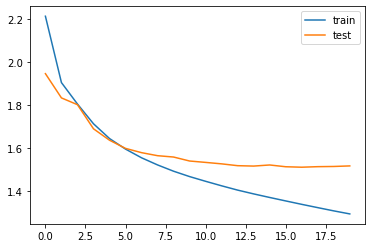

In [ ]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [ ]:
# Guardar todo el modelo  https://www.tensorflow.org/tutorials/keras/save_and_load
model.save_weights('/content/drive/MyDrive/Modelos/WeightsM_rev-mar22')

In [ ]:
model.load_weights('/content/drive/MyDrive/Modelos/WeightsM_rev-mar22')

#Modelo de Inferencia y Generación de Texto

In [ ]:
## Inferencia del codificador
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

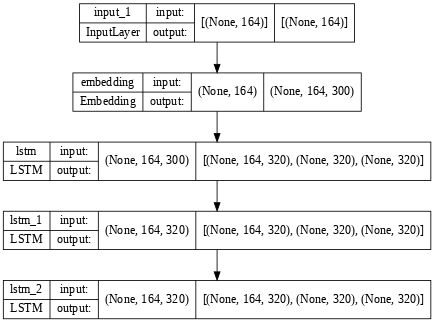

In [ ]:
tf.keras.utils.plot_model( 
    encoder_model,
    to_file="encoder_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

In [ ]:
# Inferencia del decodificador

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(int(longitud_max_reseña), latent_dim))

# Obtener los embeddings de la secuencia del decodificador 
dec_emb2 = dec_emb_layer(decoder_inputs)

# Para predecir la siguiente palabra, el estado inicial se iguala al estado del tiempo anterior
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#Inferencia en modulo de atención
attention = BahdanauAttention(latent_dim)
context_vector, _ = attention( decoder_outputs2, decoder_hidden_state_input,)
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, context_vector])

# Se utiliza la capa con activación softmax para generar la distribución de probabilidad del vocabulario objetivo
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Modelo final del decoder
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

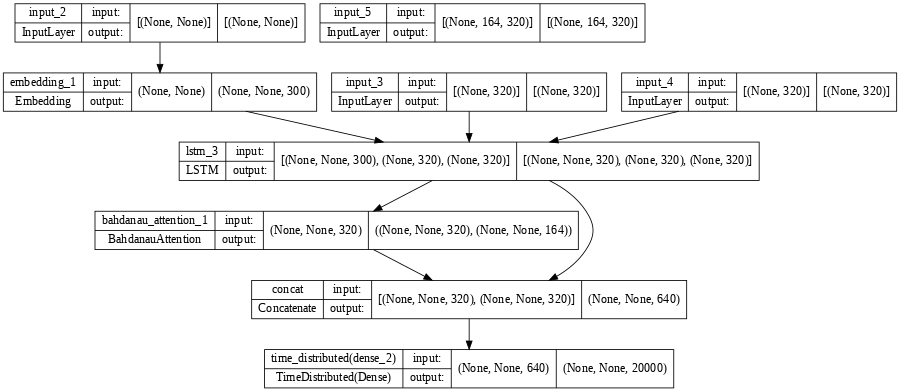

In [ ]:
tf.keras.utils.plot_model( 
    decoder_model,
    to_file="model_decoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

## Predicciones


**Implementación del modelo de inferencia **
[fuente](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

In [ ]:
i = 307
texto = x_test.iloc[i]
texto_seq = pad_sequences([vectorizer_reseña(texto)], maxlen = int(longitud_max_reseña), padding='post')
texto

'everyone keeps saying that these taste just like girl scout cookies and i will admit that the taste is similar however do not do what i did and having never eaten a fiber bar go into this expecting it to really taste like a cookie if you are on a diet you know that you start to get used to foods that do not taste quite the same as their more fattening alternatives well this is a similar deal yes they are good no they are not cookies '

In [ ]:
crea_resumen(texto_seq.reshape(1, -1))

' not for me'

In [ ]:
import random  # 10 13 31 59
palabras = texto.split()
random.Random(10).shuffle(palabras,)
texto2=' '.join(palabras)
texto_seq2 = pad_sequences([vectorizer_reseña(texto2)], maxlen = int(longitud_max_reseña), padding='post')
texto2

'cookie really no that quite admit start not used fiber are it i this just fattening same more alternatives is do good are will like their foods bar cookies is not a eaten and you deal similar get are go to i taste diet everyone expecting saying what to having that a they girl do like similar they and never the a know this as on if taste that taste you a scout taste yes the not however into do to did keeps cookies that you these well'

In [ ]:
crea_resumen(texto_seq2.reshape(1, -1))

' not bad'

<h3> Comparación del resumen generado por la rnn con el resumen original

In [ ]:
for i in range(35,40):
  print(i)
  print("Reseña:",seq2text(x_test_seq[i]))
  print("Resumen original:",seq2summary(y_test_seq[i]))
  print("Resumen generado:",crea_resumen(x_test_seq[i].reshape(1, -1)))
  print("\n")

35
Reseña: buy this and you will not regret it good quality dark chocolate adds a delicious flavor good healthy snack too for kids 
Resumen original: best granola ever kids hooked on it too 
Resumen generado:  great


36
Reseña: this is the chocolate product to get if you or your kids have food [UNK] allergies it is one of the only chocolates on the market that does not contain lecithin but only the english imported version lindt changed their receipe so now we cannot eat it i do not feel drained and [UNK] after eating it and my kid does not get [UNK] weird [UNK] after eating this we thought it was the sugar that made him react but after oodles of research we found out that the lecithin was the primary [UNK] hope this review helps others plus it tastes divine like it should 
Resumen original: yum 
Resumen generado:  great for kids with a


37
Reseña: i love this product it is great for anyone who is trying to cut back on calories but does not want to give up flavor really chocolaty hav

In [ ]:
for i in range(5,10):
  print(i)
  print("Reseña:",seq2text(x_test_seq[i]))
  print("Resumen original:",seq2summary(y_test_seq[i]))
  print("Resumen generado:",crea_resumen(x_test_seq[i].reshape(1, -1)))
  print("\n")

5
Reseña: this is always my first cup of coffee for the day strong but very smooth it never fails to wake me up and get me going and it is very nice to have the 50 pack available 
Resumen original: great coffee 
Resumen generado:  great


6
Reseña: i love this stuff it is just too messy i use dried [UNK] extract now but you have to be [UNK] with it too 
Resumen original: [UNK] 
Resumen generado:  great for the price


7
Reseña: this ghee has a great buttery flavor but is very very soupy i have used other [UNK] which were are solid at room temperature this one is not and i do not care for that 
Resumen original: great flavor but very soupy 
Resumen generado:  not as good as the original


8
Reseña: this is the best coconut water out there i have tried the tetra packs and they taste gross not as naturally sweet i also love the chunks i could drink 2 or more of these a day wish it was a little cheaper but the thai coconuts do make a difference so it worth it 
Resumen original: amazing add

In [ ]:
for i in range(305,310):
  print(i)
  print("Reseña:",seq2text(x_test_seq[i]))
  print("Resumen original:",seq2summary(y_test_seq[i]))
  print("Resumen generado:",crea_resumen(x_test_seq[i].reshape(1, -1)))
  print("\n")

305
Reseña: our 20 month twins love these they are very convenient and usually pretty neat i called the company because our upc matched a [UNK] recall number from january of 2010 and they were very helpful in explaining the three ways to tell that it was not from that batch wagon wheel top cheer pack on the back and expiration that would expire no more than 15 months from may of 2010 further more they were confident that the [UNK] recall got back all the products with faulty packaging very satisfied with this product and the flavor is good 
Resumen original: great on the go food 
Resumen generado:  great for the price


306
Reseña: just love these crackers especially the cinnamon hearts even my 22 month old [UNK] thinks they are a tasty treat 
Resumen original: best crackers 
Resumen generado:  yummy


307
Reseña: everyone keeps saying that these taste just like girl scout cookies and i will admit that the taste is similar however do not do what i did and having never eaten a fiber bar